In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [2]:
dataPath='static/dataset_new/train'

In [3]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in ["Closed", "Open"]:
        path = os.path.join(folder, label)
        class_num = 0 if label == "Closed" else 1
        for filename in os.listdir(path):
            img = cv2.imread(os.path.join(path, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Griye çevirme
                img = cv2.resize(img, (64, 64))  # Yeniden boyutlandırma
                images.append(img)
                labels.append(class_num)
    return np.array(images), np.array(labels)

images, labels = load_images_from_folder(dataPath)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Verileri normalize et
X_train = X_train / 255.0
X_test = X_test / 255.0

# Verileri kategorik hale getir
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)


In [6]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)


In [10]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\oguzc\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,624,834 (6.20 MB)

 Trainable params: 1,624,834 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# EarlyStopping ve ModelCheckpoint callback fonksiyonları
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)


In [12]:
history = model.fit(train_generator, 
                    validation_data=(X_test, y_test), 
                    epochs=50, 
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
 4/31 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5501 - loss: 0.8666

c:\Users\oguzc\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5381 - loss: 0.7834 - val_accuracy: 0.8421 - val_loss: 0.6098
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7683 - loss: 0.5327 - val_accuracy: 0.8704 - val_loss: 0.3014
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8296 - loss: 0.3824 - val_accuracy: 0.9028 - val_loss: 0.2851
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8591 - loss: 0.3247 - val_accuracy: 0.9069 - val_loss: 0.2869
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8704 - loss: 0.3016 - val_accuracy: 0.9190 - val_loss: 0.2552
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9132 - loss: 0.2324 - val_accuracy: 0.9150 - val_loss: 0.2591
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9019 - loss: 0.2386 - val_accuracy: 0.9271 - val_loss: 0.2423
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9299 - loss: 0.1892 - val_accuracy: 0.9514 - val_loss: 0.

In [17]:
model.save('best-model.h5')

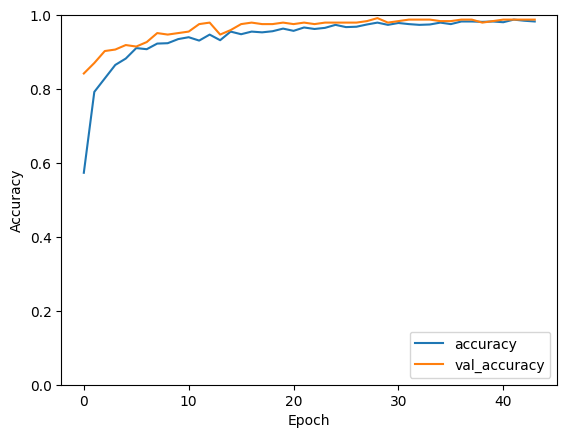

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [16]:
def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    
    prediction = model.predict(img)
    if np.argmax(prediction) == 0:
        return "Closed"
    else:
        return "Open"

example_image_path = dataPath + "/Open/_0.jpg"
print(predict_image(example_image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Open
